# Import packages

In [78]:
# Standard packages
import pandas as pd
import numpy as np
import pickle

# Sklearn
from sklearn.model_selection import StratifiedKFold, StratifiedShuffleSplit
from sklearn.metrics import mean_squared_error
from sklearn.manifold import TSNE

# LGBM
from lightgbm import LGBMRegressor

# Keras
from keras.layers import Input, Embedding, Flatten, Dot, Dense, Concatenate, Dropout
from keras.models import Model
from keras.callbacks import EarlyStopping
from keras.utils.vis_utils import plot_model
from IPython.display import SVG

# Plotly
import plotly.express as px

In [3]:
!pip install pydot
!pip install graphviz

In [4]:
%load_ext autoreload
%autoreload 2

# Load data

In [5]:
dataset = pd.read_csv('./data/preprocessed/merged_dataset.csv')
dataset.head()

,id,track_id,band_id,influencer_id,influencer_kind,score,Acid house_band,African music_band,Alternative rock_band,Ambient_band,...,Singer-songwriter_influencer,Soul_influencer,Surf rock_influencer,Synthpop_influencer,Synthwave_influencer,Techno_influencer,Traditional Music_influencer,Trap_influencer,Trip hop_influencer,Variété Française_influencer
0,7312,324,303,102,4,0.0,0,0,0,0,...,0,0,0,0,0,1,0,0,1,0
1,7313,324,303,103,10,0.0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,7314,324,303,104,3,0.0,0,0,0,0,...,0,1,0,0,0,0,0,1,0,1
3,7315,324,303,105,1,1.0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
4,7316,324,303,106,6,0.0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0


# Split data

For stability measures of models, let us assess performance doing 5-Fold cross validation:

one model kind will be trained 5 times, and its score will be averaged over the 5 out of sample sets.

Stratified 5 Fold on `score` is performed so the target is welll distributed over the different splits.

In [6]:
N_FOLDS = 5
RANDOM_SEED = 42

/!\ Ids from tracks, bands and influencers are not allowed to be used since we are creating a **Content-Based** recommender system.

This allows to avoid the cold start problem of only considering **Collaborative Filtering** but can be a loss of information for **Hybrid** recommender systems.

In [7]:
X = dataset.drop(columns=['id', 'track_id', 'band_id', 'influencer_id', 'score'])
y = dataset.score
skf = StratifiedKFold(n_splits=N_FOLDS, shuffle=True, random_state=RANDOM_SEED)

In [8]:
skf.get_n_splits(X, y)
print(skf)

StratifiedKFold(n_splits=5, random_state=42, shuffle=True)


# Naive models

**Root Mean Squared Error** averaged over the 5 out of sample datasets will be the performance metric.

* Naive model : predicting score mean (computed of train sets) on test. Its score should be close to standard deviation of test

* Random model : predicting [0, 1] random uniform score on test

In [15]:
std_train_mean = 0.0
std_test_mean = 0.0
naive_score = 0.0
random_score =  0.0

## y is transformed to an integer so skf can be performed
for train_index, test_index in skf.split(X, (y * 100).astype(int)):
    
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    std_train_mean += np.std(y_train)
    std_test_mean += np.std(y_test)
    naive_score += np.sqrt(mean_squared_error([y_train.mean()] * len(y_test), y_test))
    random_score += np.sqrt(mean_squared_error(np.random.uniform(0, 1, size=len(y_test)), y_test))

std_train_mean /= N_FOLDS
std_test_mean /= N_FOLDS
naive_score /= N_FOLDS
random_score /= N_FOLDS

In [16]:
print(f'\nAverage standard deviation of score on in sample sets: {std_train_mean}')
print(f'\nAverage standard deviation of score on out of sample sets: {std_test_mean}')
print(f'\nAverage RMSE of naive model on out of sample sets: {naive_score}')
print(f'\nAverage RMSE of random uniform model on out of sample sets: {random_score}')


Average standard deviation of score on in sample sets: 0.39570093979500703

Average standard deviation of score on out of sample sets: 0.39570093963773195

Average RMSE of naive model on out of sample sets: 0.3957009399899617

Average RMSE of random uniform model on out of sample sets: 0.5503498753830948


# LGBM model

Let us train a LGBM model early stopped on 10% of in sample datasets.

In [92]:
lgbm_score =  0.0


for train_index, test_index in skf.split(X, (y * 100).astype(int)):
    
    X_train, X_test = X.values[train_index], X.values[test_index]
    y_train, y_test = y.values[train_index], y.values[test_index]
    
    sss = StratifiedShuffleSplit(n_splits=1, test_size=0.1, random_state=RANDOM_SEED)
    tridx, vidx = next(sss.split(X_train, (y_train * 100).astype(int)))
    X_train, X_valid = X_train[tridx], X_train[vidx]
    y_train, y_valid = y_train[tridx], y_train[vidx]
    
    lgbm = LGBMRegressor(
        num_leaves=2**10,
        learning_rate=0.01,
        subsample=0.5,
        reg_alpha=10.0,
        reg_lambda=10.0,
        n_estimators=10000,
        silent=False
    )
    lgbm.fit(X_train, y_train, eval_set=(X_valid, y_valid), 
             eval_metric='mse', early_stopping_rounds=100,
             verbose=500)
    lgbm_score += np.sqrt(mean_squared_error(lgbm.predict(X_test), y_test))

lgbm_score /= N_FOLDS

Training until validation scores don't improve for 100 rounds
[500]	valid_0's l2: 0.0947876
[1000]	valid_0's l2: 0.092996
[1500]	valid_0's l2: 0.0926348
[2000]	valid_0's l2: 0.0926313
[2500]	valid_0's l2: 0.0926313
[3000]	valid_0's l2: 0.0926313
[3500]	valid_0's l2: 0.0926313
[4000]	valid_0's l2: 0.0926313
[4500]	valid_0's l2: 0.0926313
[5000]	valid_0's l2: 0.0926313
[5500]	valid_0's l2: 0.0926313
[6000]	valid_0's l2: 0.0926313
[6500]	valid_0's l2: 0.0926313
Early stopping, best iteration is:
[6559]	valid_0's l2: 0.0926313
Training until validation scores don't improve for 100 rounds
[500]	valid_0's l2: 0.0973691
[1000]	valid_0's l2: 0.0953712
[1500]	valid_0's l2: 0.0950005
Early stopping, best iteration is:
[1647]	valid_0's l2: 0.0949962
Training until validation scores don't improve for 100 rounds
[500]	valid_0's l2: 0.096489
[1000]	valid_0's l2: 0.094622
[1500]	valid_0's l2: 0.0942171
[2000]	valid_0's l2: 0.0940687
Early stopping, best iteration is:
[2018]	valid_0's l2: 0.0940683
Tr

In [93]:
print(f'LGBM score: {lgbm_score}')

LGBM score: 0.308811089530982


# First Keras models

In [19]:
band_data = X.filter(regex='_band')
influencer_data = X.filter(regex='_influencer')

influencer_kind = X.influencer_kind
i_kind_idx = X.columns.get_loc('influencer_kind')

b_data_idx = [X.columns.get_loc(c) for c in band_data]
i_data_idx = [X.columns.get_loc(c) for c in influencer_data]

## Simple dot product model

In [30]:
def build_Dot_model(
    i_emb_dim=16, 
    b_emb_dim=16,
    activation='relu'
):
    """
    Build simple MLP Neural Network.
    """
    # Influencer embedding
    influencer_input = Input(shape=[influencer_data.shape[1]], name="Influencer-Input")
    influencer_embedding = Dense(i_emb_dim, activation=activation, name="Influencer-Embedding")(influencer_input)
    
    # Band embedding
    band_input = Input(shape=[band_data.shape[1]], name="Band-Input")
    band_embedding = Dense(b_emb_dim, activation=activation, name="Band-Embedding")(band_input)
    
    # Concatenate and create product
    prod = Dot(name="Dot-Product", axes=-1)([influencer_embedding, band_embedding])
    
    # Output
    band_embedding_model = Model([influencer_input, band_input], band_embedding)
    influencer_embedding_model = Model([influencer_input, band_input], influencer_embedding)
    model = Model([influencer_input, band_input], prod)
    model.compile('adam', 'mean_squared_error')
    
    return model, band_embedding_model, influencer_embedding_model

### Test model and visualize embeddings

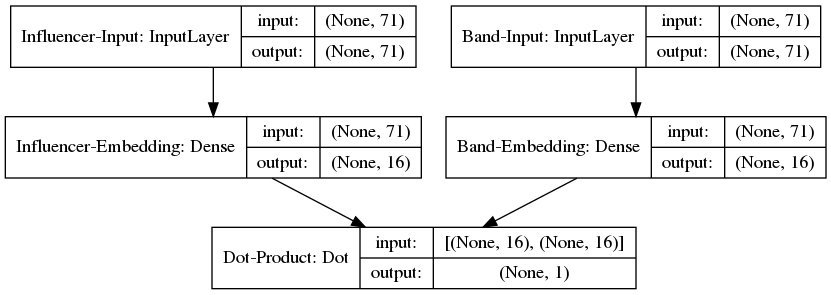

In [48]:
# Initialize model
model, band_embedding_model, influencer_embedding_model = build_Dot_model()

# Plot architecture
plot_model(model, to_file='Dot_model_plot.png', show_shapes=True, show_layer_names=True)

In [49]:
# Fit model on 10 epochs on all data
history = model.fit([influencer_data, band_data], dataset.score, epochs=20, verbose=1)

Epoch 1/20
83706/83706 [==============================] - 2s 24us/step - loss: 0.1372
Epoch 2/20
83706/83706 [==============================] - 2s 22us/step - loss: 0.1094
Epoch 3/20
83706/83706 [==============================] - 2s 22us/step - loss: 0.1016
Epoch 4/20
83706/83706 [==============================] - 2s 22us/step - loss: 0.0991
Epoch 5/20
83706/83706 [==============================] - 2s 22us/step - loss: 0.0976
Epoch 6/20
83706/83706 [==============================] - 2s 23us/step - loss: 0.0968
Epoch 7/20
83706/83706 [==============================] - 2s 24us/step - loss: 0.0964
Epoch 8/20
83706/83706 [==============================] - 2s 23us/step - loss: 0.0961
Epoch 9/20
83706/83706 [==============================] - 2s 22us/step - loss: 0.0956
Epoch 10/20
83706/83706 [==============================] - 2s 23us/step - loss: 0.0954
Epoch 11/20
83706/83706 [==============================] - 2s 22us/step - loss: 0.0952
Epoch 12/20
83706/83706 [===========================

#### Band embeddings

In [62]:
# Extract Band embeddings and perform 2D TSNE

b_em = model.get_layer('Band-Embedding')
b_em_weights = b_em.get_weights()[0]

tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tnse_results = tsne.fit_transform(b_em_weights)

fig = px.scatter(x=tnse_results[:,0], y=tnse_results[:,1], text=[col[:-5] for col in band_data.columns])
fig.show()

[t-SNE] Computing 70 nearest neighbors...
[t-SNE] Indexed 71 samples in 0.000s...
[t-SNE] Computed neighbors for 71 samples in 0.001s...
[t-SNE] Computed conditional probabilities for sample 71 / 71
[t-SNE] Mean sigma: 0.557261
[t-SNE] KL divergence after 250 iterations with early exaggeration: 53.845135
[t-SNE] KL divergence after 300 iterations: 0.770831


#### Influencer embeddings

In [58]:
# Extract Influencer embeddings and perform 2D TSNE

i_em = model.get_layer('Influencer-Embedding')
i_em_weights = i_em.get_weights()[0]

tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tnse_results = tsne.fit_transform(b_em_weights)

fig = px.scatter(x=tnse_results[:,0], y=tnse_results[:,1], text=[col[:-11] for col in influencer_data.columns])
fig.show()

[t-SNE] Computing 70 nearest neighbors...
[t-SNE] Indexed 71 samples in 0.000s...
[t-SNE] Computed neighbors for 71 samples in 0.001s...
[t-SNE] Computed conditional probabilities for sample 71 / 71
[t-SNE] Mean sigma: 0.557261
[t-SNE] KL divergence after 250 iterations with early exaggeration: 49.742256
[t-SNE] KL divergence after 300 iterations: 0.771352


TSNE is not very stable on this example because we lack data.

## Train model with cross validation and early stopping

In [64]:
EPOCHS = 100
PATIENCE = 5
BATCH_SIZE = 32

nn_score = 0.0

for train_index, test_index in skf.split(X, (y * 100).astype(int)):
    
    X_train, X_test = X.values[train_index], X.values[test_index]
    y_train, y_test = y.values[train_index], y.values[test_index]
    
    sss = StratifiedShuffleSplit(n_splits=1, test_size=0.1, random_state=RANDOM_SEED)
    tridx, vidx = next(sss.split(X_train, (y_train * 100).astype(int)))
    X_train, X_valid = X_train[tridx], X_train[vidx]
    y_train, y_valid = y_train[tridx], y_train[vidx]
    
    # Build model
    model, band_embedding_model, influencer_embedding_model = build_Dot_model()
    
    # Early stopping callback
    es = EarlyStopping(
        monitor='val_loss', 
        mode='min', 
        patience=PATIENCE,
        restore_best_weights=True,
        verbose=1
    )
    
    # Fit
    model.fit([X_train[:, i_data_idx], X_train[:, b_data_idx]], y_train,
              validation_data=([X_valid[:, i_data_idx], X_valid[:, b_data_idx]], y_valid), 
              batch_size=BATCH_SIZE,
              epochs=EPOCHS,
              callbacks=[es],
              verbose=1)
    
    nn_score += np.sqrt(mean_squared_error(
        model.predict([X_test[:, i_data_idx], X_test[:, b_data_idx]]), y_test
    ))

nn_score /= N_FOLDS

Train on 60267 samples, validate on 6697 samples
Epoch 1/100
60267/60267 [==============================] - 2s 29us/step - loss: 0.1450 - val_loss: 0.1186
Epoch 2/100
60267/60267 [==============================] - 1s 24us/step - loss: 0.1123 - val_loss: 0.1083
Epoch 3/100
60267/60267 [==============================] - 1s 24us/step - loss: 0.1053 - val_loss: 0.1034
Epoch 4/100
60267/60267 [==============================] - 1s 24us/step - loss: 0.1017 - val_loss: 0.1033
Epoch 5/100
60267/60267 [==============================] - 1s 24us/step - loss: 0.0997 - val_loss: 0.1002
Epoch 6/100
60267/60267 [==============================] - 1s 24us/step - loss: 0.0979 - val_loss: 0.0996
Epoch 7/100
60267/60267 [==============================] - 1s 24us/step - loss: 0.0973 - val_loss: 0.0992
Epoch 8/100
60267/60267 [==============================] - 1s 24us/step - loss: 0.0964 - val_loss: 0.0988
Epoch 9/100
60267/60267 [==============================] - 1s 24us/step - loss: 0.0958 - val_loss: 0.09

60268/60268 [==============================] - 2s 25us/step - loss: 0.0941 - val_loss: 0.0989
Restoring model weights from the end of the best epoch
Epoch 00019: early stopping
Train on 60268 samples, validate on 6697 samples
Epoch 1/100
60268/60268 [==============================] - 2s 31us/step - loss: 0.1447 - val_loss: 0.1197
Epoch 2/100
60268/60268 [==============================] - 2s 25us/step - loss: 0.1159 - val_loss: 0.1109
Epoch 3/100
60268/60268 [==============================] - 2s 26us/step - loss: 0.1084 - val_loss: 0.1058
Epoch 4/100
60268/60268 [==============================] - 2s 27us/step - loss: 0.1038 - val_loss: 0.1032
Epoch 5/100
60268/60268 [==============================] - 2s 26us/step - loss: 0.1012 - val_loss: 0.1028
Epoch 6/100
60268/60268 [==============================] - 2s 26us/step - loss: 0.0996 - val_loss: 0.1005
Epoch 7/100
60268/60268 [==============================] - 2s 26us/step - loss: 0.0986 - val_loss: 0.1001
Epoch 8/100
60268/60268 [=======

In [65]:
print(f'NN score: {nn_score}')

NN score: 0.31624817489734414


## Simple Deep Model

In [66]:
def build_NN_model(
    i_emb_dim=16, 
    b_emb_dim=16, 
    kind_emb_dim=8, 
    last_dense=16, 
    dropout=0.2,
    activation='relu'
):
    """
    Build simple MLP Neural Network.
    """
    # Influencer embedding
    influencer_input = Input(shape=[influencer_data.shape[1]], name="Influencer-Input")
    influencer_embedding = Dense(i_emb_dim, activation=activation, name="Influencer-Embedding")(influencer_input)
    
    # Influencer kind categorical embedding
    influencer_kind_input = Input(shape=[1], name="Influencer-Kind-Input")
    influencer_kind_emb = Embedding(
        influencer_kind.nunique(), 
        kind_emb_dim, 
        name="Influencer-Kind-Embedding"
    )(influencer_kind_input)
    
    # Concatenate influencer emb with influencer kind emb to get full influencer emb
    influencer_full_emb = Concatenate(name="Influencer-Full-Embedding", axis=-1)(
        [influencer_embedding, Flatten(name='Flatten')(influencer_kind_emb)]
    )
    
    # Band embedding
    band_input = Input(shape=[band_data.shape[1]], name="Band-Input")
    band_embedding = Dense(b_emb_dim, activation=activation, name="Band-Embedding")(band_input)
    
    # Concatenate and create product
    concat = Concatenate(name="Concat", axis=-1)([influencer_full_emb, band_embedding])
    dense = Dense(last_dense, activation=activation, name="Dense")(concat)
    
    # Dropout
    dropout = Dropout(rate=dropout)(dense)
    
    # Output
    output = Dense(1, activation=activation, name="Output")(dropout)
    band_embedding_model = Model([influencer_input, band_input, influencer_kind_input], band_embedding)
    influencer_embedding_model = Model([influencer_input, band_input, influencer_kind_input],
                                       influencer_full_emb)
    model = Model([influencer_input, band_input, influencer_kind_input], output)
    model.compile('adam', 'mean_squared_error')
    
    return model, band_embedding_model, influencer_embedding_model

### Test model and visualize embeddings

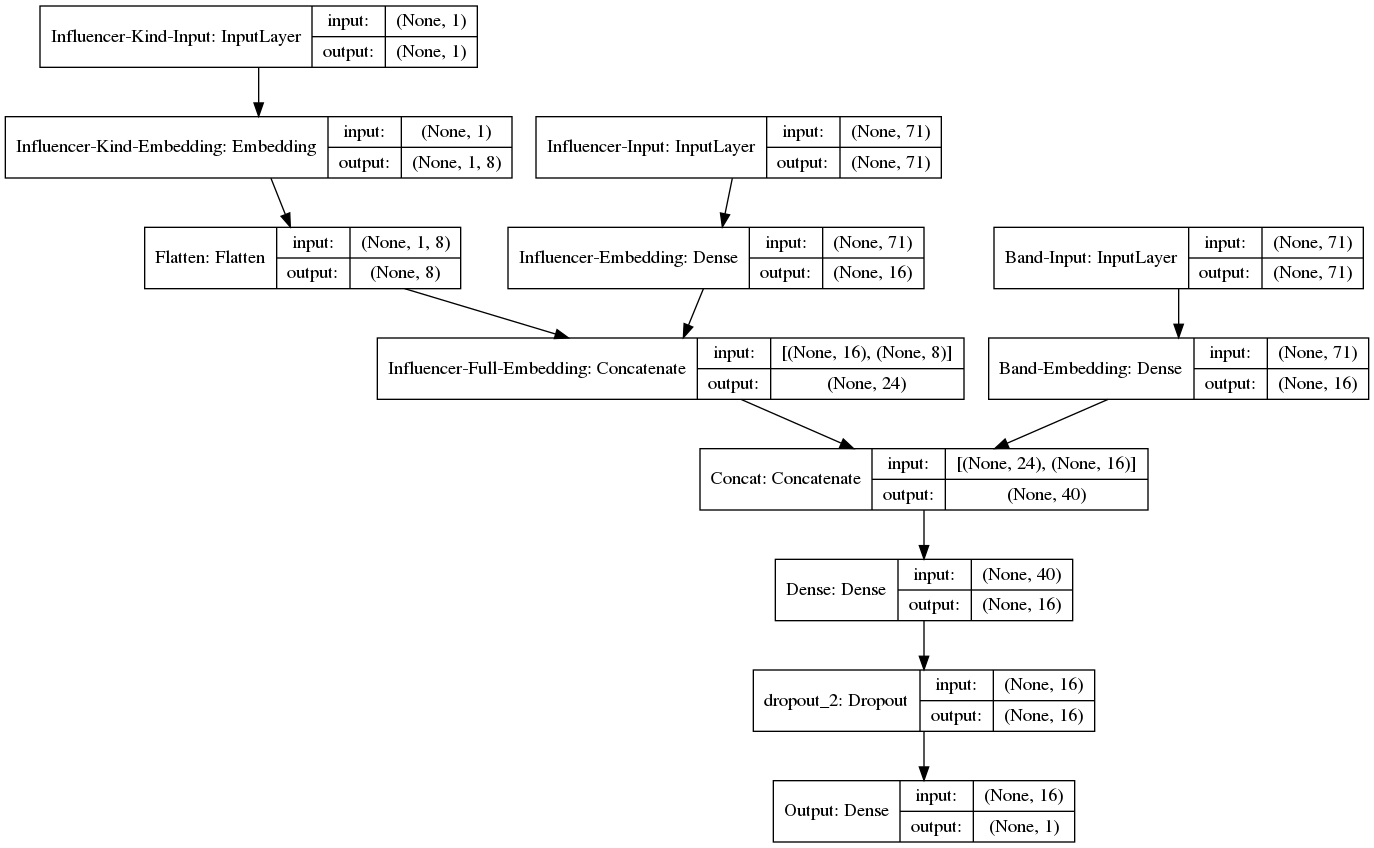

In [69]:
# Initialize model
model, band_embedding_model, influencer_embedding_model = build_NN_model()

# Plot architecture
plot_model(model, to_file='Dot_model_plot.png', show_shapes=True, show_layer_names=True)

In [71]:
# Fit model on 10 epochs on all data
history = model.fit([influencer_data, band_data, influencer_kind], dataset.score, epochs=20, verbose=1)

Epoch 1/20
83706/83706 [==============================] - 3s 35us/step - loss: 0.1216
Epoch 2/20
83706/83706 [==============================] - 2s 28us/step - loss: 0.1070
Epoch 3/20
83706/83706 [==============================] - 2s 28us/step - loss: 0.1035
Epoch 4/20
83706/83706 [==============================] - 2s 28us/step - loss: 0.1013
Epoch 5/20
83706/83706 [==============================] - 2s 29us/step - loss: 0.1002
Epoch 6/20
83706/83706 [==============================] - 2s 28us/step - loss: 0.0993
Epoch 7/20
83706/83706 [==============================] - 2s 29us/step - loss: 0.0988
Epoch 8/20
83706/83706 [==============================] - 2s 28us/step - loss: 0.0985
Epoch 9/20
83706/83706 [==============================] - 2s 29us/step - loss: 0.0977
Epoch 10/20
83706/83706 [==============================] - 2s 29us/step - loss: 0.0974
Epoch 11/20
83706/83706 [==============================] - 2s 29us/step - loss: 0.0969
Epoch 12/20
83706/83706 [===========================

#### Band embeddings

In [75]:
# Extract Band embeddings and perform 2D TSNE

b_em = model.get_layer('Band-Embedding')
b_em_weights = b_em.get_weights()[0]

tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tnse_results = tsne.fit_transform(b_em_weights)

fig = px.scatter(x=tnse_results[:,0], y=tnse_results[:,1], text=[col[:-5] for col in band_data.columns])
fig.show()

[t-SNE] Computing 70 nearest neighbors...
[t-SNE] Indexed 71 samples in 0.000s...
[t-SNE] Computed neighbors for 71 samples in 0.001s...
[t-SNE] Computed conditional probabilities for sample 71 / 71
[t-SNE] Mean sigma: 0.816457
[t-SNE] KL divergence after 250 iterations with early exaggeration: 53.252708
[t-SNE] KL divergence after 300 iterations: 1.046860


#### Influencer embeddings

In [87]:
# Extract Influencer embeddings and perform 2D TSNE

i_em = model.get_layer('Influencer-Embedding')
i_em_weights = i_em.get_weights()[0]

tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tnse_results = tsne.fit_transform(i_em_weights)

fig = px.scatter(x=tnse_results[:,0], y=tnse_results[:,1], text=[col[:-11] for col in influencer_data.columns])
fig.show()

[t-SNE] Computing 70 nearest neighbors...
[t-SNE] Indexed 71 samples in 0.000s...
[t-SNE] Computed neighbors for 71 samples in 0.001s...
[t-SNE] Computed conditional probabilities for sample 71 / 71
[t-SNE] Mean sigma: 0.814674
[t-SNE] KL divergence after 250 iterations with early exaggeration: 55.328049
[t-SNE] KL divergence after 300 iterations: 0.878721


#### Influencer kind embeddings

In [85]:
with open('./data/preprocessed/influencer_kind_label_encoder.pickle', 'rb') as f:
    le = pickle.load(f)
    
ik_em = model.get_layer('Influencer-Kind-Embedding')
ik_em_weights = ik_em.get_weights()[0]

tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tnse_results = tsne.fit_transform(ik_em_weights)

fig = px.scatter(x=tnse_results[:,0], y=tnse_results[:,1], text=list(le.classes_))
fig.show()

[t-SNE] Computing 12 nearest neighbors...
[t-SNE] Indexed 13 samples in 0.000s...
[t-SNE] Computed neighbors for 13 samples in 0.001s...
[t-SNE] Computed conditional probabilities for sample 13 / 13
[t-SNE] Mean sigma: 1125899906842624.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 57.594818
[t-SNE] KL divergence after 300 iterations: 0.396849


In [89]:
EPOCHS = 100
PATIENCE = 5
BATCH_SIZE = 32

nn_score = 0.0

for train_index, test_index in skf.split(X, (y * 100).astype(int)):
    
    X_train, X_test = X.values[train_index], X.values[test_index]
    y_train, y_test = y.values[train_index], y.values[test_index]
    
    sss = StratifiedShuffleSplit(n_splits=1, test_size=0.1, random_state=RANDOM_SEED)
    tridx, vidx = next(sss.split(X_train, (y_train * 100).astype(int)))
    X_train, X_valid = X_train[tridx], X_train[vidx]
    y_train, y_valid = y_train[tridx], y_train[vidx]
    
    # Build model
    model, band_embedding_model, influencer_embedding_model = build_NN_model()
    
    # Early stopping callback
    es = EarlyStopping(
        monitor='val_loss', 
        mode='min', 
        patience=PATIENCE,
        restore_best_weights=True,
        verbose=1
    )
    
    # Fit
    model.fit([X_train[:, i_data_idx], X_train[:, b_data_idx], X_train[:, i_kind_idx]], y_train,
              validation_data=([X_valid[:, i_data_idx], X_valid[:, b_data_idx], X_valid[:, i_kind_idx]], y_valid), 
              batch_size=BATCH_SIZE,
              epochs=EPOCHS,
              callbacks=[es],
              verbose=1)
    
    nn_score += np.sqrt(mean_squared_error(
        model.predict([X_test[:, i_data_idx], X_test[:, b_data_idx], X_test[:, i_kind_idx]]), y_test
    ))

nn_score /= N_FOLDS

Train on 60267 samples, validate on 6697 samples
Epoch 1/100
60267/60267 [==============================] - 3s 48us/step - loss: 0.1284 - val_loss: 0.1047
Epoch 2/100
60267/60267 [==============================] - 2s 35us/step - loss: 0.1056 - val_loss: 0.0990
Epoch 3/100
60267/60267 [==============================] - 2s 35us/step - loss: 0.1027 - val_loss: 0.0980
Epoch 4/100
60267/60267 [==============================] - 2s 34us/step - loss: 0.1007 - val_loss: 0.0968
Epoch 5/100
60267/60267 [==============================] - 2s 34us/step - loss: 0.0999 - val_loss: 0.0955
Epoch 6/100
60267/60267 [==============================] - 2s 35us/step - loss: 0.0992 - val_loss: 0.0961
Epoch 7/100
60267/60267 [==============================] - 2s 35us/step - loss: 0.0984 - val_loss: 0.0954
Epoch 8/100
60267/60267 [==============================] - 2s 35us/step - loss: 0.0979 - val_loss: 0.0951
Epoch 9/100
60267/60267 [==============================] - 2s 35us/step - loss: 0.0976 - val_loss: 0.09

Epoch 25/100
60268/60268 [==============================] - 2s 34us/step - loss: 0.0955 - val_loss: 0.0952
Restoring model weights from the end of the best epoch
Epoch 00025: early stopping
Train on 60268 samples, validate on 6697 samples
Epoch 1/100
60268/60268 [==============================] - 3s 49us/step - loss: 0.1271 - val_loss: 0.1054
Epoch 2/100
60268/60268 [==============================] - 2s 34us/step - loss: 0.1091 - val_loss: 0.0988
Epoch 3/100
60268/60268 [==============================] - 2s 34us/step - loss: 0.1048 - val_loss: 0.0967
Epoch 4/100
60268/60268 [==============================] - 2s 34us/step - loss: 0.1029 - val_loss: 0.0957
Epoch 5/100
60268/60268 [==============================] - 2s 34us/step - loss: 0.1020 - val_loss: 0.0951
Epoch 6/100
60268/60268 [==============================] - 2s 34us/step - loss: 0.1007 - val_loss: 0.0966
Epoch 7/100
60268/60268 [==============================] - 2s 35us/step - loss: 0.1003 - val_loss: 0.0936
Epoch 8/100
60268/6

In [90]:
print(f'NN score: {nn_score}')

NN score: 0.30981423403005004


In [96]:
EPOCHS = 100
PATIENCE = 10
BATCH_SIZE = 32

nn_score = 0.0

for train_index, test_index in skf.split(X, (y * 100).astype(int)):
    
    X_train, X_test = X.values[train_index], X.values[test_index]
    y_train, y_test = y.values[train_index], y.values[test_index]
    
    sss = StratifiedShuffleSplit(n_splits=1, test_size=0.1, random_state=RANDOM_SEED)
    tridx, vidx = next(sss.split(X_train, (y_train * 100).astype(int)))
    X_train, X_valid = X_train[tridx], X_train[vidx]
    y_train, y_valid = y_train[tridx], y_train[vidx]
    
    # Build model
    model, band_embedding_model, influencer_embedding_model = build_NN_model(dropout=0.1)
    
    # Early stopping callback
    es = EarlyStopping(
        monitor='val_loss', 
        mode='min', 
        patience=PATIENCE,
        restore_best_weights=True,
        verbose=1
    )
    
    # Fit
    model.fit([X_train[:, i_data_idx], X_train[:, b_data_idx], X_train[:, i_kind_idx]], y_train,
              validation_data=([X_valid[:, i_data_idx], X_valid[:, b_data_idx], X_valid[:, i_kind_idx]], y_valid), 
              batch_size=BATCH_SIZE,
              epochs=EPOCHS,
              callbacks=[es],
              verbose=1)
    
    nn_score += np.sqrt(mean_squared_error(
        model.predict([X_test[:, i_data_idx], X_test[:, b_data_idx], X_test[:, i_kind_idx]]), y_test
    ))

nn_score /= N_FOLDS

Train on 60267 samples, validate on 6697 samples
Epoch 1/100
60267/60267 [==============================] - 4s 73us/step - loss: 0.1233 - val_loss: 0.1039
Epoch 2/100
60267/60267 [==============================] - 3s 46us/step - loss: 0.1051 - val_loss: 0.0987
Epoch 3/100
60267/60267 [==============================] - 3s 51us/step - loss: 0.1018 - val_loss: 0.0991
Epoch 4/100
60267/60267 [==============================] - 3s 46us/step - loss: 0.1002 - val_loss: 0.0963
Epoch 5/100
60267/60267 [==============================] - 3s 45us/step - loss: 0.0991 - val_loss: 0.0973
Epoch 6/100
60267/60267 [==============================] - 3s 46us/step - loss: 0.0983 - val_loss: 0.0963
Epoch 7/100
60267/60267 [==============================] - 3s 43us/step - loss: 0.0977 - val_loss: 0.0963
Epoch 8/100
60267/60267 [==============================] - 3s 44us/step - loss: 0.0973 - val_loss: 0.0970
Epoch 9/100
60267/60267 [==============================] - 3s 45us/step - loss: 0.0969 - val_loss: 0.09

Epoch 12/100
60268/60268 [==============================] - 2s 40us/step - loss: 0.0960 - val_loss: 0.0944
Epoch 13/100
60268/60268 [==============================] - 2s 40us/step - loss: 0.0956 - val_loss: 0.0959
Epoch 14/100
60268/60268 [==============================] - 3s 42us/step - loss: 0.0953 - val_loss: 0.0946
Epoch 15/100
60268/60268 [==============================] - 2s 41us/step - loss: 0.0949 - val_loss: 0.0942
Epoch 16/100
60268/60268 [==============================] - 2s 40us/step - loss: 0.0948 - val_loss: 0.0945
Epoch 17/100
60268/60268 [==============================] - 2s 40us/step - loss: 0.0946 - val_loss: 0.0951
Epoch 18/100
60268/60268 [==============================] - 3s 42us/step - loss: 0.0942 - val_loss: 0.0948
Epoch 19/100
60268/60268 [==============================] - 2s 41us/step - loss: 0.0939 - val_loss: 0.0945
Epoch 20/100
60268/60268 [==============================] - 2s 40us/step - loss: 0.0938 - val_loss: 0.0957
Epoch 21/100
60268/60268 [===========

In [97]:
print(f'NN score: {nn_score}')

NN score: 0.30963655165140275


In [ ]:
nn_score = 0.0

for train_index, test_index in skf.split(X, (y * 100).astype(int)):
    
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    sss = StratifiedShuffleSplit(n_splits=1, test_size=0.3, random_state=RANDOM_SEED)
    tridx, vidx = next(sss.split(X_train, (y_train * 100).astype(int)))
    X_train, X_valid = X_train[tridx], X_train[vidx]
    y_train, y_valid = y_train[tridx], y_train[vidx]
    
    model = build_model()
    model.fit([X_train[:, i_data_idx], X_train[:, b_data_idx]], y_train,
              validation_data=([X_valid[:, i_data_idx], X_valid[:, b_data_idx]], y_valid), 
              batch_size=64,
              epochs=10,
              verbose=1)
    
    nn_score += np.sqrt(mean_squared_error(model.predict([X_test[:, i_data_idx], X_test[:, b_data_idx]]), y_test))

nn_score /= N_FOLDS

In [ ]:
print(f'NN score: {nn_score}')

In [315]:
def build_model(i_emb_dim=50, b_emb_dim=50):
    """
    """
    influencer_input = Input(shape=[i_data.shape[1]], name="Influencer-Input")
    influencer_embedding = Dense(i_emb_dim, activation='tanh', name="Influencer-Embedding")(influencer_input)
    
    band_input = Input(shape=[b_data.shape[1]], name="Band-Input")
    band_embedding = Dense(b_emb_dim, activation='tanh', name="Band-Embedding")(band_input)
    
    prod = Dot(name="Dot-Product", axes=1)([influencer_embedding, band_embedding])
    model = Model([influencer_input, band_input], prod)
    model.compile('adam', 'mean_squared_error')
    
    return model

In [39]:
# model.save('regression_model.h5')

In [316]:
X, y = (
    dataset.drop(columns='score').rename(
        {'Variété Française_x': 'Variete Francaise_x', 'Variété Française_y': 'Variete Francaise_y'},
        axis=1
    ).values,
    dataset.score.values
)

In [317]:
i_data = dataset.filter(regex='_y')
b_data = dataset.filter(regex='_x')

In [318]:
i_data_idx = [dataset.drop(columns='score').columns.get_loc(c) for c in dataset.filter(regex='_y')]
b_data_idx = [dataset.drop(columns='score').columns.get_loc(c) for c in dataset.filter(regex='_x')]

In [319]:
dataset.columns.get_loc('Variété Française_y')

147

In [320]:
dataset.shape

(83706, 148)

In [321]:
nn_score = 0.0

for train_index, test_index in skf.split(X, (y * 100).astype(int)):
    
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    sss = StratifiedShuffleSplit(n_splits=1, test_size=0.3, random_state=RANDOM_SEED)
    tridx, vidx = next(sss.split(X_train, (y_train * 100).astype(int)))
    X_train, X_valid = X_train[tridx], X_train[vidx]
    y_train, y_valid = y_train[tridx], y_train[vidx]
    
    model = build_model()
    model.fit([X_train[:, i_data_idx], X_train[:, b_data_idx]], y_train,
              validation_data=([X_valid[:, i_data_idx], X_valid[:, b_data_idx]], y_valid), 
              batch_size=64,
              epochs=10,
              verbose=1)
    
    nn_score += np.sqrt(mean_squared_error(model.predict([X_test[:, i_data_idx], X_test[:, b_data_idx]]), y_test))

nn_score /= N_FOLDS

Train on 46874 samples, validate on 20090 samples
Epoch 1/10
46874/46874 [==============================] - 7s 150us/step - loss: 0.2231 - val_loss: 0.1751
Epoch 2/10
46874/46874 [==============================] - 4s 75us/step - loss: 0.1512 - val_loss: 0.1471
Epoch 3/10
46874/46874 [==============================] - 4s 76us/step - loss: 0.1372 - val_loss: 0.1382
Epoch 4/10
46874/46874 [==============================] - 4s 75us/step - loss: 0.1299 - val_loss: 0.1347
Epoch 5/10
46874/46874 [==============================] - 4s 76us/step - loss: 0.1240 - val_loss: 0.1358
Epoch 6/10
46874/46874 [==============================] - 4s 75us/step - loss: 0.1208 - val_loss: 0.1293
Epoch 7/10
46874/46874 [==============================] - 4s 75us/step - loss: 0.1175 - val_loss: 0.1253
Epoch 8/10
46874/46874 [==============================] - 4s 76us/step - loss: 0.1153 - val_loss: 0.1221
Epoch 9/10
46874/46874 [==============================] - 4s 77us/step - loss: 0.1129 - val_loss: 0.1193
Epoc

In [68]:
print(f'NN score: {nn_score}')

NameError: name 'nn_score' is not defined

In [73]:
dataset.influencer_kind.nunique()

13

In [322]:
def build_model_2(i_emb_dim=50, b_emb_dim=50, kind_emb_dim=5, last_dense=20, dropout=0.2):
    """
    """
    # Influencer embedding
    influencer_input = Input(shape=[i_data.shape[1]], name="Influencer-Input")
    influencer_embedding = Dense(i_emb_dim, activation='tanh', name="Influencer-Embedding")(influencer_input)
    
    # Influencer kind categorical embedding
    influencer_kind_input = Input(shape=[1], name="Influencer-Kind-Input")
    influencer_kind_emb = Embedding(14, kind_emb_dim, name="Influencer-Kind-Embedding")(influencer_kind_input)
    
    # Concatenate influencer emb with influencer kind emb to get full influencer emb
    influencer_full_emb = Concatenate(axis=-1)([influencer_embedding, Flatten(name='Flatten')(influencer_kind_emb)])
    
    # Band embedding
    band_input = Input(shape=[b_data.shape[1]], name="Band-Input")
    band_embedding = Dense(b_emb_dim, activation='tanh', name="Band-Embedding")(band_input)
    
    # Concatenate and create product
    prod = Concatenate(name="Concat", axis=-1)([influencer_full_emb, band_embedding])
    prod2 = Dense(last_dense, activation='tanh', name="Dense1")(prod)
    dropout = Dropout(rate=dropout)(prod2)
    
    # Dropout
    prod3 = Dense(1, activation='tanh', name="Dense2")(dropout)
    model = Model([influencer_input, band_input, influencer_kind_input], prod3)
    model.compile('adam', 'mean_squared_error')
    
    return model

In [323]:
def build_model_3(i_emb_dim=60, b_emb_dim=60, kind_emb_dim=10, last_dense=40, dropout=0.3):
    """
    """
    # Influencer embedding
    influencer_input = Input(shape=[i_data.shape[1]], name="Influencer-Input")
    influencer_embedding = Dense(i_emb_dim, activation='relu', name="Influencer-Embedding1")(influencer_input)
    influencer_embedding = Dense(last_dense, activation='relu', name="Dense1")(influencer_embedding)
    influencer_embedding = Dense(i_emb_dim-10, activation='relu', name="Influencer-Embedding")(influencer_embedding)
    
    # Influencer kind categorical embedding
    influencer_kind_input = Input(shape=[1], name="Influencer-Kind-Input")
    influencer_kind_emb = Embedding(14, kind_emb_dim, name="Influencer-Kind-Embedding")(influencer_kind_input)
    
    # Concatenate influencer emb with influencer kind emb to get full influencer emb
    influencer_full_emb = Concatenate(axis=-1)([influencer_embedding, Flatten(name='Flatten')(influencer_kind_emb)])
    
    # Band embedding
    band_input = Input(shape=[b_data.shape[1]], name="Band-Input")
    band_embedding = Dense(b_emb_dim, activation='relu', name="Band-Embedding1")(band_input)
    band_embedding = Dense(last_dense, activation='relu', name="Dense2")(band_embedding)
    band_embedding = Dense(b_emb_dim-10, activation='relu', name="Band-Embedding")(band_embedding)
    
    # Concatenate and create product
    prod = Concatenate(name="Concat", axis=-1)([influencer_full_emb, band_embedding])
    prod2 = Dense(last_dense, activation='relu', name="Dense0")(prod)
    dropout = Dropout(rate=dropout)(prod2)
    
    # Dropout
    prod3 = Dense(1, activation='relu', name="Dense3")(dropout)
    model = Model([influencer_input, band_input, influencer_kind_input], prod3)
    model.compile('adam', 'mean_squared_error')
    
    return model

In [324]:
dataset.head()

,id,track_id,band_id,influencer_id,influencer_kind,score,Acid house_x,African music_x,Alternative rock_x,Ambient_x,...,Singer-songwriter_y,Soul_y,Surf rock_y,Synthpop_y,Synthwave_y,Techno_y,Traditional Music_y,Trap_y,Trip hop_y,Variété Française_y
0,7312,324,303,102,4,0.0,0,0,0,0,...,0,0,0,0,0,1,0,0,1,0
1,7313,324,303,103,10,0.0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,7314,324,303,104,3,0.0,0,0,0,0,...,0,1,0,0,0,0,0,1,0,1
3,7315,324,303,105,1,1.0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
4,7316,324,303,106,6,0.0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0


In [334]:
nn_score = 0.0

for train_index, test_index in skf.split(X, (y * 100).astype(int)):
    
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    sss = StratifiedShuffleSplit(n_splits=1, test_size=0.3, random_state=RANDOM_SEED)
    tridx, vidx = next(sss.split(X_train, (y_train * 100).astype(int)))
    X_train, X_valid = X_train[tridx], X_train[vidx]
    y_train, y_valid = y_train[tridx], y_train[vidx]
    
    # Build model
    model = build_model_3()
    
    # Early stoppnig callback
    es = keras.callbacks.EarlyStopping(
        monitor='val_loss', 
        mode='min', 
        patience=PATIENCE,
        restore_best_weights=True,
        verbose=1
    )
    
    # Fit
    model.fit([X_train[:, i_data_idx], X_train[:, b_data_idx], X_train[:, 5]], y_train,
              validation_data=([X_valid[:, i_data_idx], X_valid[:, b_data_idx], X_valid[:, 5]], y_valid), 
              batch_size=BATCH_SIZE,
              epochs=EPOCHS,
              callbacks=[es],
              verbose=1)
    
    nn_score += np.sqrt(mean_squared_error(
        model.predict([X_test[:, i_data_idx], X_test[:, b_data_idx], X_test[:, 5]]), y_test
    ))

nn_score /= N_FOLDS

print(nn_score)

Train on 46874 samples, validate on 20090 samples
Epoch 1/10000
46874/46874 [==============================] - 16s 334us/step - loss: 0.1167 - val_loss: 0.1042
Epoch 2/10000
46874/46874 [==============================] - 11s 232us/step - loss: 0.1032 - val_loss: 0.0989
Epoch 3/10000
46874/46874 [==============================] - 11s 229us/step - loss: 0.1003 - val_loss: 0.0977
Epoch 4/10000
46874/46874 [==============================] - 11s 238us/step - loss: 0.0993 - val_loss: 0.0954
Epoch 5/10000
46874/46874 [==============================] - 11s 237us/step - loss: 0.0974 - val_loss: 0.0975
Epoch 6/10000
46874/46874 [==============================] - 11s 231us/step - loss: 0.0965 - val_loss: 0.0953
Epoch 7/10000
46874/46874 [==============================] - 11s 230us/step - loss: 0.0959 - val_loss: 0.0949
Epoch 8/10000
46874/46874 [==============================] - 11s 232us/step - loss: 0.0951 - val_loss: 0.0945
Epoch 9/10000
46874/46874 [==============================] - 10s 223us

Epoch 20/10000
46875/46875 [==============================] - 11s 233us/step - loss: 0.0903 - val_loss: 0.0973
Epoch 21/10000
46875/46875 [==============================] - 11s 232us/step - loss: 0.0898 - val_loss: 0.0979
Epoch 22/10000
46875/46875 [==============================] - 11s 233us/step - loss: 0.0898 - val_loss: 0.0968
Epoch 23/10000
46875/46875 [==============================] - 11s 232us/step - loss: 0.0894 - val_loss: 0.0980
Epoch 24/10000
46875/46875 [==============================] - 11s 232us/step - loss: 0.0892 - val_loss: 0.0977
Epoch 25/10000
46875/46875 [==============================] - 11s 233us/step - loss: 0.0888 - val_loss: 0.0970
Epoch 26/10000
46875/46875 [==============================] - 11s 232us/step - loss: 0.0887 - val_loss: 0.0970
Epoch 27/10000
46875/46875 [==============================] - 11s 231us/step - loss: 0.0882 - val_loss: 0.0968
Epoch 28/10000
46875/46875 [==============================] - 11s 234us/step - loss: 0.0884 - val_loss: 0.0969
E

Epoch 40/10000
46875/46875 [==============================] - 11s 238us/step - loss: 0.0845 - val_loss: 0.0991
Epoch 41/10000
46875/46875 [==============================] - 11s 239us/step - loss: 0.0845 - val_loss: 0.0982
Epoch 42/10000
46875/46875 [==============================] - 11s 239us/step - loss: 0.0846 - val_loss: 0.0998
Epoch 43/10000
46875/46875 [==============================] - 11s 237us/step - loss: 0.0846 - val_loss: 0.0979
Epoch 44/10000
46875/46875 [==============================] - 11s 239us/step - loss: 0.0837 - val_loss: 0.0980
Epoch 45/10000
46875/46875 [==============================] - 11s 238us/step - loss: 0.0838 - val_loss: 0.1009
Epoch 46/10000
46875/46875 [==============================] - 11s 239us/step - loss: 0.0839 - val_loss: 0.0994
Epoch 47/10000
46875/46875 [==============================] - 11s 239us/step - loss: 0.0831 - val_loss: 0.0996
Epoch 48/10000
46875/46875 [==============================] - 11s 239us/step - loss: 0.0832 - val_loss: 0.0980
E

In [335]:
nn_score = 0.0

for train_index, test_index in skf.split(X, (y * 100).astype(int)):
    
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    sss = StratifiedShuffleSplit(n_splits=1, test_size=0.3, random_state=RANDOM_SEED)
    tridx, vidx = next(sss.split(X_train, (y_train * 100).astype(int)))
    X_train, X_valid = X_train[tridx], X_train[vidx]
    y_train, y_valid = y_train[tridx], y_train[vidx]
    
    # Build model
    model = build_model_3(80, 80, 5, 50, 0.3)
    
    # Early stoppnig callback
    es = keras.callbacks.EarlyStopping(
        monitor='val_loss', 
        mode='min', 
        patience=PATIENCE,
        restore_best_weights=True,
        verbose=1
    )
    
    # Fit
    model.fit([X_train[:, i_data_idx], X_train[:, b_data_idx], X_train[:, 5]], y_train,
              validation_data=([X_valid[:, i_data_idx], X_valid[:, b_data_idx], X_valid[:, 5]], y_valid), 
              batch_size=BATCH_SIZE,
              epochs=EPOCHS,
              callbacks=[es],
              verbose=1)
    
    nn_score += np.sqrt(mean_squared_error(
        model.predict([X_test[:, i_data_idx], X_test[:, b_data_idx], X_test[:, 5]]), y_test
    ))

nn_score /= N_FOLDS

print(nn_score)

Train on 46874 samples, validate on 20090 samples
Epoch 1/10000
46874/46874 [==============================] - 16s 346us/step - loss: 0.1133 - val_loss: 0.0995
Epoch 2/10000
46874/46874 [==============================] - 11s 242us/step - loss: 0.1032 - val_loss: 0.0976
Epoch 3/10000
46874/46874 [==============================] - 11s 242us/step - loss: 0.0996 - val_loss: 0.0965
Epoch 4/10000
46874/46874 [==============================] - 11s 242us/step - loss: 0.0985 - val_loss: 0.0965
Epoch 5/10000
46874/46874 [==============================] - 11s 242us/step - loss: 0.0970 - val_loss: 0.0953
Epoch 6/10000
46874/46874 [==============================] - 11s 243us/step - loss: 0.0962 - val_loss: 0.0978
Epoch 7/10000
46874/46874 [==============================] - 11s 243us/step - loss: 0.0955 - val_loss: 0.0945
Epoch 8/10000
46874/46874 [==============================] - 11s 244us/step - loss: 0.0947 - val_loss: 0.0953
Epoch 9/10000
46874/46874 [==============================] - 11s 243us

Epoch 20/10000
46875/46875 [==============================] - 15s 309us/step - loss: 0.0899 - val_loss: 0.0978
Epoch 21/10000
46875/46875 [==============================] - 15s 312us/step - loss: 0.0892 - val_loss: 0.0970
Epoch 22/10000
46875/46875 [==============================] - 15s 310us/step - loss: 0.0894 - val_loss: 0.0977
Epoch 23/10000
46875/46875 [==============================] - 15s 311us/step - loss: 0.0888 - val_loss: 0.0977
Epoch 24/10000
46875/46875 [==============================] - 15s 311us/step - loss: 0.0885 - val_loss: 0.0981
Epoch 25/10000
46875/46875 [==============================] - 15s 310us/step - loss: 0.0885 - val_loss: 0.0971
Epoch 26/10000
46875/46875 [==============================] - 15s 311us/step - loss: 0.0877 - val_loss: 0.0982
Epoch 27/10000
46875/46875 [==============================] - 15s 311us/step - loss: 0.0880 - val_loss: 0.0986
Epoch 28/10000
46875/46875 [==============================] - 15s 311us/step - loss: 0.0876 - val_loss: 0.0985
E

Epoch 41/10000
46875/46875 [==============================] - 12s 254us/step - loss: 0.0833 - val_loss: 0.0976
Epoch 42/10000
46875/46875 [==============================] - 12s 254us/step - loss: 0.0835 - val_loss: 0.0977
Epoch 43/10000
46875/46875 [==============================] - 12s 254us/step - loss: 0.0829 - val_loss: 0.0997
Epoch 44/10000
46875/46875 [==============================] - 12s 254us/step - loss: 0.0829 - val_loss: 0.0987
Epoch 45/10000
46875/46875 [==============================] - 12s 254us/step - loss: 0.0826 - val_loss: 0.0987
Epoch 46/10000
46875/46875 [==============================] - 12s 254us/step - loss: 0.0823 - val_loss: 0.0987
Epoch 47/10000
46875/46875 [==============================] - 12s 254us/step - loss: 0.0822 - val_loss: 0.0990
Epoch 48/10000
46875/46875 [==============================] - 12s 254us/step - loss: 0.0823 - val_loss: 0.0993
Epoch 49/10000
46875/46875 [==============================] - 12s 253us/step - loss: 0.0818 - val_loss: 0.0986
E

In [336]:
nn_score = 0.0

for train_index, test_index in skf.split(X, (y * 100).astype(int)):
    
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    sss = StratifiedShuffleSplit(n_splits=1, test_size=0.3, random_state=RANDOM_SEED)
    tridx, vidx = next(sss.split(X_train, (y_train * 100).astype(int)))
    X_train, X_valid = X_train[tridx], X_train[vidx]
    y_train, y_valid = y_train[tridx], y_train[vidx]
    
    # Build model
    model = build_model_3(80, 80, 5, 50, 0.5)
    
    # Early stoppnig callback
    es = keras.callbacks.EarlyStopping(
        monitor='val_loss', 
        mode='min', 
        patience=PATIENCE,
        restore_best_weights=True,
        verbose=1
    )
    
    # Fit
    model.fit([X_train[:, i_data_idx], X_train[:, b_data_idx], X_train[:, 5]], y_train,
              validation_data=([X_valid[:, i_data_idx], X_valid[:, b_data_idx], X_valid[:, 5]], y_valid), 
              batch_size=BATCH_SIZE,
              epochs=EPOCHS,
              callbacks=[es],
              verbose=1)
    
    nn_score += np.sqrt(mean_squared_error(
        model.predict([X_test[:, i_data_idx], X_test[:, b_data_idx], X_test[:, 5]]), y_test
    ))

nn_score /= N_FOLDS

print(nn_score)

Train on 46874 samples, validate on 20090 samples
Epoch 1/10000
46874/46874 [==============================] - 17s 367us/step - loss: 0.1194 - val_loss: 0.1088
Epoch 2/10000
46874/46874 [==============================] - 12s 255us/step - loss: 0.1048 - val_loss: 0.0991
Epoch 3/10000
46874/46874 [==============================] - 12s 256us/step - loss: 0.1018 - val_loss: 0.0973
Epoch 4/10000
46874/46874 [==============================] - 12s 255us/step - loss: 0.1000 - val_loss: 0.1009
Epoch 5/10000
46874/46874 [==============================] - 12s 256us/step - loss: 0.0990 - val_loss: 0.0964
Epoch 6/10000
46874/46874 [==============================] - 12s 255us/step - loss: 0.0984 - val_loss: 0.0956
Epoch 7/10000
46874/46874 [==============================] - 12s 256us/step - loss: 0.0971 - val_loss: 0.0955
Epoch 8/10000
46874/46874 [==============================] - 12s 256us/step - loss: 0.0963 - val_loss: 0.0952
Epoch 9/10000
46874/46874 [==============================] - 12s 257us

Epoch 15/10000
46875/46875 [==============================] - 12s 259us/step - loss: 0.0933 - val_loss: 0.0958
Epoch 16/10000
46875/46875 [==============================] - 12s 259us/step - loss: 0.0925 - val_loss: 0.0968
Epoch 17/10000
46875/46875 [==============================] - 12s 261us/step - loss: 0.0925 - val_loss: 0.0966
Epoch 18/10000
46875/46875 [==============================] - 12s 259us/step - loss: 0.0921 - val_loss: 0.0974
Epoch 19/10000
46875/46875 [==============================] - 12s 260us/step - loss: 0.0916 - val_loss: 0.0964
Epoch 20/10000
46875/46875 [==============================] - 12s 260us/step - loss: 0.0914 - val_loss: 0.0959
Epoch 21/10000
46875/46875 [==============================] - 12s 261us/step - loss: 0.0914 - val_loss: 0.0969
Epoch 22/10000
46875/46875 [==============================] - 12s 260us/step - loss: 0.0909 - val_loss: 0.0972
Epoch 23/10000
46875/46875 [==============================] - 12s 259us/step - loss: 0.0908 - val_loss: 0.0971
E

Epoch 38/10000
46875/46875 [==============================] - 12s 263us/step - loss: 0.0880 - val_loss: 0.0980
Epoch 39/10000
46875/46875 [==============================] - 12s 263us/step - loss: 0.0881 - val_loss: 0.0974
Epoch 40/10000
46875/46875 [==============================] - 12s 264us/step - loss: 0.0875 - val_loss: 0.0997
Epoch 41/10000
46875/46875 [==============================] - 12s 264us/step - loss: 0.0875 - val_loss: 0.0981
Epoch 42/10000
46875/46875 [==============================] - 12s 263us/step - loss: 0.0875 - val_loss: 0.0984
Epoch 43/10000
46875/46875 [==============================] - 12s 264us/step - loss: 0.0872 - val_loss: 0.0989
Epoch 44/10000
46875/46875 [==============================] - 12s 263us/step - loss: 0.0875 - val_loss: 0.0989
Epoch 45/10000
46875/46875 [==============================] - 12s 264us/step - loss: 0.0869 - val_loss: 0.0983
Epoch 46/10000
46875/46875 [==============================] - 12s 266us/step - loss: 0.0867 - val_loss: 0.0979
E

# Embedding visualization

In [359]:
def build_model_3(i_emb_dim=60, b_emb_dim=60, kind_emb_dim=10, last_dense=40, dropout=0.3):
    """
    """
    # Influencer embedding
    influencer_input = Input(shape=[i_data.shape[1]], name="Influencer-Input")
    influencer_embedding = Dense(i_emb_dim, activation='relu', name="Influencer-Embedding1")(influencer_input)
    influencer_embedding = Dense(last_dense, activation='relu', name="Dense1")(influencer_embedding)
    influencer_embedding = Dense(i_emb_dim-10, activation='relu', name="Influencer-Embedding")(influencer_embedding)
    
    # Influencer kind categorical embedding
    influencer_kind_input = Input(shape=[1], name="Influencer-Kind-Input")
    influencer_kind_emb = Embedding(14, kind_emb_dim, name="Influencer-Kind-Embedding")(influencer_kind_input)
    
    # Concatenate influencer emb with influencer kind emb to get full influencer emb
    influencer_full_emb = Concatenate(axis=-1)([influencer_embedding, Flatten(name='Flatten')(influencer_kind_emb)])
    
    # Band embedding
    band_input = Input(shape=[b_data.shape[1]], name="Band-Input")
    band_embedding = Dense(b_emb_dim, activation='relu', name="Band-Embedding1")(band_input)
    band_embedding = Dense(last_dense, activation='relu', name="Dense2")(band_embedding)
    band_embedding = Dense(b_emb_dim-10, activation='relu', name="Band-Embedding")(band_embedding)
    
    # Concatenate and create product
    prod = Concatenate(name="Concat", axis=-1)([influencer_full_emb, band_embedding])
    prod2 = Dense(last_dense, activation='relu', name="Dense0")(prod)
    dropout = Dropout(rate=dropout)(prod2)
    prod_ = Dense(50, activation='relu', name="Dense_")(prod2)
    drop = Dropout(rate=0.3)(prod_)
    
    # Dropout
    prod3 = Dense(1, activation='relu', name="Dense3")(drop)
    model = Model([influencer_input, band_input, influencer_kind_input], prod3)
    model.compile('adam', 'mean_squared_error')
    
    return model

In [360]:
nn_score = 0.0

for train_index, test_index in skf.split(X, (y * 100).astype(int)):
    
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    sss = StratifiedShuffleSplit(n_splits=1, test_size=0.3, random_state=RANDOM_SEED)
    tridx, vidx = next(sss.split(X_train, (y_train * 100).astype(int)))
    X_train, X_valid = X_train[tridx], X_train[vidx]
    y_train, y_valid = y_train[tridx], y_train[vidx]
    
    # Build model
    model = build_model_3(80, 80, 8, 100, 0.3)
    
    # Early stoppnig callback
    es = keras.callbacks.EarlyStopping(
        monitor='val_loss', 
        mode='min', 
        patience=PATIENCE,
        restore_best_weights=True,
        verbose=1
    )
    
    # Fit
    model.fit([X_train[:, i_data_idx], X_train[:, b_data_idx], X_train[:, 5]], y_train,
              validation_data=([X_valid[:, i_data_idx], X_valid[:, b_data_idx], X_valid[:, 5]], y_valid), 
              batch_size=BATCH_SIZE,
              epochs=EPOCHS,
              callbacks=[es],
              verbose=1)
    
    nn_score += np.sqrt(mean_squared_error(
        model.predict([X_test[:, i_data_idx], X_test[:, b_data_idx], X_test[:, 5]]), y_test
    ))

nn_score /= N_FOLDS

print(nn_score)

Train on 46874 samples, validate on 20090 samples
Epoch 1/10000
46874/46874 [==============================] - 21s 438us/step - loss: 0.1130 - val_loss: 0.1007
Epoch 2/10000
46874/46874 [==============================] - 14s 293us/step - loss: 0.1022 - val_loss: 0.0998
Epoch 3/10000
46874/46874 [==============================] - 14s 291us/step - loss: 0.0992 - val_loss: 0.0965
Epoch 4/10000
46874/46874 [==============================] - 14s 290us/step - loss: 0.0978 - val_loss: 0.0970
Epoch 5/10000
46874/46874 [==============================] - 14s 290us/step - loss: 0.0962 - val_loss: 0.0962
Epoch 6/10000
46874/46874 [==============================] - 14s 290us/step - loss: 0.0950 - val_loss: 0.0967
Epoch 7/10000
46874/46874 [==============================] - 14s 290us/step - loss: 0.0938 - val_loss: 0.0956
Epoch 8/10000
46874/46874 [==============================] - 14s 290us/step - loss: 0.0934 - val_loss: 0.0957
Epoch 9/10000
46874/46874 [==============================] - 14s 302us

Epoch 30/10000
46875/46875 [==============================] - 14s 294us/step - loss: 0.0735 - val_loss: 0.1061
Epoch 31/10000
46875/46875 [==============================] - 14s 293us/step - loss: 0.0721 - val_loss: 0.1083
Epoch 32/10000
46875/46875 [==============================] - 14s 294us/step - loss: 0.0712 - val_loss: 0.1057
Epoch 33/10000
46875/46875 [==============================] - 14s 293us/step - loss: 0.0708 - val_loss: 0.1093
Epoch 34/10000
46875/46875 [==============================] - 14s 294us/step - loss: 0.0702 - val_loss: 0.1069
Epoch 35/10000
46875/46875 [==============================] - 14s 294us/step - loss: 0.0694 - val_loss: 0.1096
Epoch 36/10000
46875/46875 [==============================] - 14s 293us/step - loss: 0.0688 - val_loss: 0.1098
Epoch 37/10000
46875/46875 [==============================] - 14s 292us/step - loss: 0.0683 - val_loss: 0.1118
Epoch 38/10000
46875/46875 [==============================] - 14s 294us/step - loss: 0.0680 - val_loss: 0.1110
E

Epoch 57/10000
46875/46875 [==============================] - 14s 301us/step - loss: 0.0625 - val_loss: 0.1128
Epoch 58/10000
46875/46875 [==============================] - 14s 301us/step - loss: 0.0628 - val_loss: 0.1136
Restoring model weights from the end of the best epoch
Epoch 00058: early stopping
0.3100033573517424


* Add README : 
    * install requirements.txt in venv
    * store data in `./data/raw/`
    * install graphviz (sudo apt-get ...)
    * run notebooks from 01 to ..
* Visualize model
* Visualize embeddings

* Check pipe
* Add L2 reg
* look for text embeddings
* preprocess text
* build archi
* print archi
* pretrained emb
* tqdm notebook

Content based : no interaction influencer/artist taken into account (no embedding for them)

advantage : cold start allowed
disadvantage : interesting info lossed

==> hybrid recommender system

label encoded influencer kind : in production, a category 'Other' can be created to account for potential kinds not present in current dataset.

Grid search

track info ==> proxy of song ID ==> potential leak for this dataset